# Домашнее задание 3. 

## Предсказание пользовательской оценки отеля по тексту отзыва.

Драмбян Давид

Мы собрали для вас отзывы по 1500 отелям из совершенно разных уголков мира. Что это за отели - секрет. Вам дан текст отзыва и пользовательская оценка отеля. Ваша задача - научиться предсказывать оценку отеля по отзыву. Данные можно скачать [тут](https://www.kaggle.com/c/hseds-texts-2020/data?select=train.csv).

Главная метрика - Mean Absolute Error (MAE). Во всех частях домашней работы вам нужно получить значение MAE не превышающее 1. В противном случае мы будем вынуждены не засчитать задание :( 

Для измерения качества вашей модели используйте разбиение данных на train и test и замеряйте качество на тестовой части.

#### Про данные:
Каждое ревью состоит из двух текстов: positive и negative - плюсы и минусы отеля. В столбце score находится оценка пользователя - вещественное число 0 до 10. Вам нужно извлечь признаки из этих текстов и предсказать по ним оценку.

Удачи! 💪

#### Использовать внешние данные для обучения строго запрещено. Можно использовать предобученные модели из torchvision.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
PATH_TO_TRAIN_DATA = '../input/hseds-texts-2020/train.csv'# 'hseds-texts-2020/train.csv'

In [3]:
df = pd.read_csv(PATH_TO_TRAIN_DATA)
df.head()

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,No Positive,7.1
1,00004d18f186bf2489590dc415876f73,TV not working,No Positive,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,Very business,Location,5.4
4,00025e1aa3ac32edb496db49e76bbd00,Rooms could do with a bit of a refurbishment ...,Nice breakfast handy for Victoria train stati...,6.7


Предобработка текста может сказываться на качестве вашей модели.
Сделаем небольшой препроцессинг текстов: удалим знаки препинания, приведем все слова к нижнему регистру. 
Однако можно не ограничиваться этим набором преобразований. Подумайте, что еще можно сделать с текстами, чтобы помочь будущим моделям? Добавьте преобразования, которые могли бы помочь по вашему мнению.

Также мы добавили разбиение текстов на токены. Теперь каждая строка-ревью стала массивом токенов.

In [3]:
import string

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer

# добавим лемматизацию слов
lemmatizer = WordNetLemmatizer() 
stemmer = PorterStemmer()

def process_text(text):
    return ' '.join([stemmer.stem(word) for word in word_tokenize(text.lower()) if word not in string.punctuation])

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [6]:
df['negative'][9995]

' Very bad neighbourhood Too noisy especially at late night Room walls are like paper you can hear the person breathing in the next room Room doors are extremely noisy you wake up when someone closes the room door '

In [7]:
df['negative'] = df['negative'].apply(process_text)
df['positive'] = df['positive'].apply(process_text)

In [8]:
df

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,there were issu with the wifi connect,no posit,7.1
1,00004d18f186bf2489590dc415876f73,tv not work,no posit,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,more pillow,beauti room great locat love staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,veri busi,locat,5.4
4,00025e1aa3ac32edb496db49e76bbd00,room could do with a bit of a refurbish as cou...,nice breakfast handi for victoria train statio...,6.7
...,...,...,...,...
99995,fffd2d3cf4eaa0db822b90c4a723cc29,no coffe facil in room air con didn t seem to ...,veri quiet for a central london hotel comfi be...,7.9
99996,fffd71432446f2d027ab2f84f759cc66,the room wa far too hot on the first night 28 ...,breakfast wa fine welcom with cava wa good,4.2
99997,fffdb752a9758baf09aa6487ab4d0780,terribl worn out mattress dust behind the head...,the well mean staff,5.0
99998,fffdd842f0b2780adec8ded4249cac6d,no neg,veri profission and nice staff veri well decor...,9.6


In [9]:
np.random.seed(13)
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df)

Соберем тренировочный и валидационный массивы и векторы результатов

In [10]:
# X_train = df_train['negative'] + ' ' + df_train['positive']
X_train = df_train['negative'] + ' ' + df_train['positive']
# X_train = df_train['negative'] + df_train['positive']
y_train = df_train['score']

# X_val = df_test['negative'] + ' ' + df_test['positive']
X_val = df_test['negative'] + ' ' + df_test['positive']
# X_val = df_test['negative'] + df_test['positive']
y_val = df_test['score']

### Часть 1. 1 балл

Обучите логистическую регрессию на TF-IDF векторах текстов.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso

In [12]:
pnkt = []
for iii in range(len(string.punctuation)):
    pnkt.append(string.punctuation[iii])

In [13]:
np.random.seed(13)

tfidf = TfidfVectorizer(stop_words=pnkt) # norm='l1', stop_words=pnkt

# tfidf.fit(X_train)
# df_train_ready = df_train['negative'] + ' ' + df_train['positive']
df_train_ready = df['negative'] + ' ' + df['positive']
tfidf.fit(df_train_ready)
X_train_tfidf = tfidf.transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

# df_X = df['negative'] + ' ' + df['positive']
# df_y = df['score']

# df_X_tfidf = tfidf.fit_transform(df_X)

In [14]:
X_train_tfidf.shape

(75000, 25397)

Обучим линейную регрессию / Lasso-регуляризированную линрег / ElasticNet-регуляризированную линрег

In [15]:
np.random.seed(13)

# lr = LinearRegression()
# lr = Lasso(alpha=0.001)
lr = ElasticNet(alpha=0.001)
lr.fit(X_train_tfidf, y_train)

lr_pred = lr.predict(X_val_tfidf)

In [16]:
print(np.sum(lr_pred > 10))

# Очевидно, оценка не больше 10, можо обрезать по максимуму :)
# lr_pred_alt0 = np.max(lr_pred, 0, axis=0)
# lr_pred_alt1 = min(lr_pred_alt0, 10)
lr_pred_alt = np.minimum(lr_pred, 10)
print(np.sum(lr_pred_alt > 10))

576
0


In [17]:
# аутпут, обрезанный 10 сверху
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# print(mean_squared_error(lr_pred, y_val))
print(mean_absolute_error(lr_pred_alt, y_val))

0.9883972691818046


In [18]:
# пустой tfidf fit на X_train, elasticnet, stemmer
# Обычный аутпут модели
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# print(mean_squared_error(lr_pred, y_val))
print(mean_absolute_error(lr_pred, y_val))

0.9940225853862256


In [19]:
X_train_tfidf[:10].shape
len(tfidf.get_feature_names())
# tfidf.get_params()
# tfidf.get_stop_words()

25397

### Часть 2. 3 балла

Обучите логистическую регрессию на усредненных Word2Vec векторах. 

In [20]:
df.isnull().sum()

review_id    0
negative     0
positive     0
score        0
dtype: int64

In [21]:
np.random.seed(13)
def process_text(text):
#     return text.split(' ')
    return [stemmer.stem(word) for word in word_tokenize(text.lower()) if word not in string.punctuation]

df = pd.read_csv(PATH_TO_TRAIN_DATA)

df['neg_pos'] = df['negative'] + ' ' + df['positive']
df['neg_pos'] = df['neg_pos'].apply(process_text)

In [22]:
np.random.seed(13)

df_train, df_test = train_test_split(df)

X_train = df_train['neg_pos']
y_train = df_train['score']

X_val = df_test['neg_pos']
y_val = df_test['score']

Добавим word2vc эмбеддинг

In [23]:
from gensim.models import Word2Vec

In [24]:
np.random.seed(13)

model = Word2Vec(sentences=X_train, size=300, min_count=5)

# model.build_vocab(X_train) 
# # model.build_vocab(df['neg_pos'])

# model.train(X_train, total_examples=model.corpus_count, epochs=5) 

In [25]:
len(model.wv.vocab)
model.corpus_count

75000

In [26]:
np.sum((model.wv['posit'] - model.wv['neg'])**2)**0.5
np.sum((model.wv['posit'] - model.wv['bad'])**2)**0.5

14.753670963010041

In [27]:
# model.wv.similarity('positive', 'good')
model.wv.similarity('posit', 'good')
model.wv.most_similar(positive=["sink"])

[('basin', 0.9039933085441589),
 ('tap', 0.8346788287162781),
 ('toilet', 0.8247793316841125),
 ('drain', 0.8074459433555603),
 ('leak', 0.7973723411560059),
 ('loos', 0.7826054692268372),
 ('holder', 0.7795525789260864),
 ('mould', 0.7756177186965942),
 ('tile', 0.7734191417694092),
 ('drainag', 0.7727153897285461)]

In [28]:
model.predict_output_word(['very', 'dirty', 'inside', 'hotel'])

[('boutiqu', 0.13301112),
 ('thi', 0.057823285),
 ('beauti', 0.019208148),
 ('itself', 0.018918088),
 ('whole', 0.0082103275),
 ('chain', 0.0064661866),
 ('4star', 0.0061561195),
 ('ha', 0.0051864595),
 ('modern', 0.004931798),
 ('overal', 0.0048768953)]

In [29]:
model.wv['posit'].shape

(300,)

In [30]:
len(model.wv.vocab)
# aaa = 0
# for i in model.wv.vocab.keys:
#     aaa += 1
# print(aaa)

dict(model.wv.vocab).keys

<function dict.keys>

In [31]:
X_train

21087    [pokey, littl, room, no, air, con, shower, eit...
58546    [no, neg, nice, balconi, outdoor, space, a, bo...
94901    [the, onli, thing, i, didn, t, like, wa, the, ...
80639    [no, neg, locat, wa, conveni, staff, alway, he...
73307    [n, a, locat, staff, and, breakfast, veri, qui...
                               ...                        
87796                       [no, neg, locat, and, qualiti]
33634    [the, staff, in, the, restaur, need, more, enc...
98378    [quit, expens, breakfast, 21, each, no, differ...
47280    [room, size, for, the, money, close, enough, t...
98642       [noth, staff, wa, superb, friendli, and, help]
Name: neg_pos, Length: 75000, dtype: object

In [32]:
X_train[0]

['there', 'were', 'issu', 'with', 'the', 'wifi', 'connect', 'no', 'posit']

In [33]:
# усредненный word2vec по текстам. X_train:
# https://habr.com/ru/company/ods/blog/329410/
X_train_avg = np.array([
            np.mean([model.wv[w] for w in sent if w in model.wv] 
                    or [np.zeros(300)], axis=0)
            for sent in X_train
            ])  

# усредненный word2vec по текстам. X_val:
X_val_avg = np.array([
            np.mean([model.wv[w] for w in sent if w in model.wv] 
                    or [np.zeros(300)], axis=0)
            for sent in X_val
            ])  

Обучим линейную регрессию на усредненных word2vec эмбеддингах

In [34]:
np.random.seed(13)

lr = LinearRegression()
# lr = Lasso(alpha=0.001)
# lr = ElasticNet(alpha=0.001)
lr.fit(X_train_avg, y_train)

lr_pred = lr.predict(X_val_avg)

In [35]:
# тот же трюк, что и в первом задании
np.sum(lr_pred > 10)
lr_pred_min = np.minimum(lr_pred, 10)
np.sum(lr_pred_min > 10)

0

In [36]:
# print(mean_squared_error(lr_pred, y_val))
print(mean_absolute_error(lr_pred_min, y_val))

0.9949691193043628


Усредняя w2v вектора, мы предполагаем, что каждое слово имеет равноценный вклад в смысл предложения, однако это может быть не совсем так. Теперь попробуйте воспользоваться другой концепцией и перевзвесить слова при получении итогового эмбеддинга текста. В качестве весов используйте IDF (Inverse document frequency)

In [37]:
print(tfidf.idf_.shape)
# tfidf.wv.vocab
len(tfidf.get_feature_names())
tfidf.get_feature_names().index('posit')
tfidf.idf_[0]

(25397,)


6.373050912693974

In [38]:
tfidf.transform(
[' '.join(X_train[21087]), ' '.join(X_train[58546])]
).shape

(2, 25397)

In [39]:
'random' in tfidf.get_feature_names()
model.wv['random'].shape

(300,)

In [40]:
# словарь слово-idf
idf_voc = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [41]:
# пересечение списков ключей 
type(model.wv.vocab.keys())
list(idf_voc.keys())

set1 = set(model.wv.vocab.keys())
set2 = set(idf_voc.keys())

# in_second_but_not_in_first = in_second - in_first

# list_of_words = list(model.wv.vocab.keys()) + list(in_second_but_not_in_first)
list_of_words = list(set1 & set2)

In [42]:
len(list_of_words)

6305

In [43]:
from tqdm import tqdm 

cnt = 0

def calc_idf(text, emb=300):
    
#     res = np.mean([model[w] * idf_voc[w] for w in text if w in list_of_words] 
#                     or [np.zeros(emb)], axis=0)

#     res = np.array([
#             np.mean([model.wv[w] * idf_voc[w] for w in sent if w in list_of_words] 
#                     or [np.zeros(emb)], axis=0)
#             for sent in text
#             ], dtype=object)

    
    # Проверка w in list_of_words работала очень долго. Погуглил. С try должно отрабатывать быстрее. 
    cnt = 0
    res = np.zeros(emb, dtype=float)
    for w in text:
        try:
            res += model.wv[w] * idf_voc[w]
            cnt += 1
        except:
            pass
        
    
    if cnt != 0:
        return res / cnt
    else: 
        return res
#     return np.mean(weightened, axis=0)

In [49]:
X_train_wnd = X_train.apply(calc_idf)
X_val_wnd = X_val.apply(calc_idf)

In [50]:
# %%capture --no-stdout --no-display
# X_train_wnd = calc_idf(X_train)

In [51]:
# X_val_wnd = calc_idf(X_val)

Обучим линеную регрессию на idf-взвешенных word2vec эмбеддингах

In [52]:
np.random.seed(13)

lr2 = LinearRegression()
# lr = Lasso(alpha=0.001)
# lr = ElasticNet(alpha=0.001)
lr2.fit(np.vstack(X_train_wnd), y_train)

lr_pred2 = lr2.predict(np.vstack(X_val_wnd))

In [53]:
np.sum(lr_pred2 > 10)
lr_pred2_min = np.minimum(lr_pred2, 10)

In [54]:
# print(mean_squared_error(lr_pred, y_val))
print(mean_absolute_error(lr_pred2, y_val))

1.0034707642160146


In [55]:
# print(mean_squared_error(lr_pred, y_val))
print(mean_absolute_error(lr_pred2_min, y_val))

0.9897260402175678


Проведите эксперименты с размерностью эмбеддинга. Для каждого из двух методов постройте график зависимости качества модели от размерности эмбеддинга. 
#### Сделайте выводы:

In [161]:
# embedding experiments. Average embedding

np.random.seed(13)

avg_res = []
for emb_size in [100, 200, 300, 400, 500]:
    print(emb_size)
    model = Word2Vec(sentences=X_train, size=emb_size, min_count=5)
    X_train_avg0 = np.array([
                np.mean([model.wv[w] for w in sent if w in model.wv] 
                        or [np.zeros(emb_size)], axis=0)
                for sent in X_train
                ])  
    X_val_avg0 = np.array([
                np.mean([model.wv[w] for w in sent if w in model.wv] 
                        or [np.zeros(emb_size)], axis=0)
                for sent in X_val
                ])  
    
    lr0 = LinearRegression()
    lr0.fit(X_train_avg0, y_train)
    lr_pred0 = lr0.predict(X_val_avg0)
    lr_pred_min0 = np.minimum(lr_pred0, 10)
    avg_res.append(mean_absolute_error(lr_pred_min0, y_val))

100
200
300
400
500


In [428]:
avg_res

[1.0259059325235054,
 1.0045561636623153,
 0.9967102300879983,
 0.9899719971034012,
 0.9849184477069882]

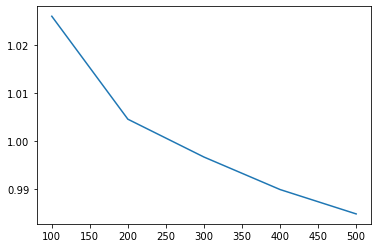

In [163]:
import matplotlib.pyplot as plt

plt.plot([100, 200, 300, 400, 500], avg_res)
plt.show()

При увеличении размера эмбеддинга, MAE уменьшается. Но скорость уменьшения тоже умешьшается/становится менее крутой(можно мыслить об этом, как об положительной второй производной). 

In [422]:
# embedding experiments. Weightened embedding

np.random.seed(13)

weightened_res = []
for emb_size in [100, 200, 300, 400, 500]:
    print(emb_size)
    model = Word2Vec(sentences=X_train, size=emb_size, min_count=5)
    idf_voc = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
    set1 = set(model.wv.vocab.keys())
    set2 = set(idf_voc.keys())
    list_of_words = list(set1 & set2)
    
    X_train_wnd0 = np.vstack(X_train.apply(calc_idf, emb=emb_size))
    X_val_wnd0 = np.vstack(X_val.apply(calc_idf, emb=emb_size))
    
    lr0 = LinearRegression()
    lr0.fit(X_train_wnd0, y_train)
    lr_pred0 = lr0.predict(X_val_wnd0)
    lr_pred_min0 = np.minimum(lr_pred0, 10)
    weightened_res.append(mean_absolute_error(lr_pred_min0, y_val))
    print(mean_absolute_error(lr_pred_min0, y_val))

100
1.0169496622452276
200
1.0003425663786132
300
0.9904099727196621
400
0.9863057256090857
500
0.981912993093244


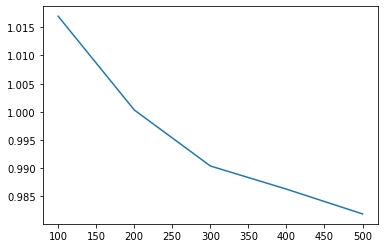

In [423]:
import matplotlib.pyplot as plt

plt.plot([100, 200, 300, 400, 500], weightened_res)
plt.show()

Аналогично. При увеличении размера эмбеддинга, MAE уменьшается. Но скорость уменьшения тоже умешьшается/становится менее крутой(можно мыслить об этом, как об положительной второй производной). 

При эмбеддинге > 200 MSE модели начинает снижаться ниже 1. 

В сравнении с усредненным word2vec по текстам, качествоо немного лучше. Если качественнее подобрать гиперпараметры и предобработать текст, качество будет лучше и разрыв между моделями тоже выше. 

Теперь попробуйте обучить логистическую регрессию на любых других эмбеддингах размерности 300 и сравните качество с Word2Vec.
#### Выводы:

In [14]:
' '.join(X_train[0])

'there were issu with the wifi connect no posit'

In [16]:
from gensim.models import FastText

ft_model = FastText(sentences=X_train, size=300, min_count=5)

In [19]:
ft_model.wv['posit'].shape

(300,)

In [20]:
X_train_ft0 = np.array([
            np.mean([ft_model.wv[w] for w in sent if w in ft_model.wv] 
                    or [np.zeros(300)], axis=0)
            for sent in X_train
            ])  
X_val_ft0 = np.array([
            np.mean([ft_model.wv[w] for w in sent if w in ft_model.wv] 
                    or [np.zeros(300)], axis=0)
            for sent in X_val
            ])  

In [21]:
np.random.seed(13)

lr0 = LinearRegression()
lr0.fit(X_train_ft0, y_train)
lr_pred0 = lr0.predict(X_val_ft0)
lr_pred_min0 = np.minimum(lr_pred0, 10)

In [23]:
print(mean_absolute_error(lr_pred0, y_val)) # обычное предсказание модели
print(mean_absolute_error(lr_pred_min0, y_val)) # предсказание модели, обрезанное сверху 10

1.0080478308665748
0.9953208631249489


Результат фасттестом получился ~ как усредненным word2vec-эмбеддингом, чуть хуже, чем взвешенным word2vec-эмбеддингом. Это вполне логично, взвешивание против усредненияя дает улучший результат. 

Сам качество с усредненным fasttext-ом против усредненного word2vec несильно отличается. Обе близки к state-of-the-art, fasttet можетт показать лучший результат, еслии поработать над би-/три-/...-граммами. 

Еще раз, если качественнее специализировать модель, разрыв между взвешенным и усредненным эмбеддингом, вероятно, увеличится(взвешивание будет менее засорено спам-словами и лучше улавливать важность слова для текста). 

### Часть 3. 6 баллов

Теперь давайте воспользуемся более продвинутыми методами обработки текстовых данных, которые мы проходили в нашем курсе. Обучите RNN/Transformer для предсказания пользовательской оценки. Получите ошибку меньше, чем во всех вышеперечисленных методах.

Если будете обучать RNN, попробуйте ограничить максимальную длину предложения. Некоторые отзывы могут быть слишком длинные относительно остальных.

Чтобы пользоваться DataLoader, все его элементы должны быть одинаковой размерности. Для этого вы можете добавить нулевой паддинг ко всем предложениям (см пример pad_sequence)

In [38]:
np.where(df_test['positive'] == 'No Positive', np.random.uniform(7, 9), np.random.uniform(8, 10))

array([8.47508244, 8.47508244, 8.47508244, ..., 8.47508244, 8.47508244,
       8.47508244])

In [43]:
np.random.seed(13)

print(np.sum(df_test['positive'] == 'No Positive'))
print(np.sum(df_test['negative'] == 'No Negative'))

lr_pred_rand0 = np.where(df_test['positive'] == 'No Positive', 
                        6, # np.random.uniform(4, 8)
                        9.5) # np.random.uniform(9, 10))
lr_pred_rand1 = np.where(df_test['negative'] == 'No Negative', 
                        9.5, # np.random.uniform(9, 10)
                        8) # np.random.uniform(5, 10))

lr_pred_rand = (lr_pred_rand0 + lr_pred_rand1) / 2
y_val = df_test['score']

mean_absolute_error(lr_pred_rand, y_val)

1621
6264


1.1458539999999997

Простая эвристика за 15 минут. Модель не сильно хуже :)))))))

In [4]:
np.random.seed(13)
def process_text(text):
#     return text.split(' ')
    return [stemmer.stem(word) for word in word_tokenize(text.lower()) if word not in string.punctuation]

df = pd.read_csv(PATH_TO_TRAIN_DATA)

df['neg_pos'] = df['negative'] + ' ' + df['positive']
df['neg_pos'] = df['neg_pos'].apply(process_text)

In [5]:
df_train, df_test = train_test_split(df)

In [6]:
import torch
from torch import nn
from torch.nn import functional as F

In [7]:
WORDS = set()
# for sent in list(df['positive']):
#     for w in sent:
#         WORDS.add(w)
        
# for sent in list(df['negative']):
#     for w in sent:
#         WORDS.add(w)

for sent in list(df['neg_pos']):
    for w in sent:
        WORDS.add(w)

In [8]:
int2word = dict(enumerate(tuple(WORDS)))
word2int = {w: ii for ii, w in int2word.items()}

In [9]:
MAX_LEN = max(max(df['positive'].apply(len)), max(df['negative'].apply(len)))
MAX_LEN = max(max(df['neg_pos'].apply(len)), max(df['neg_pos'].apply(len)))

In [10]:
MAX_LEN

633

In [11]:
from torch.nn.utils.rnn import pad_sequence

# train_pos_pad = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:MAX_LEN]) for seq in df_train['positive']], 
#                            batch_first=True)
train_pos_pad = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:MAX_LEN]) for seq in df_train['neg_pos']], 
                           batch_first=True)

In [31]:
train_pos_pad.shape
train_pos_pad[0]
# int2word[47]

for i in train_pos_pad[0]:
    print(int2word[int(i)], end='')

pokeylittlroomnoairconshowereitherhotorfreezunfriendlistaffandpoororganisofbreakfaststylishmodernideallocatforshopbartrainstationrestaurpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpovpov

In [13]:
np.random.seed(13)

def process_text(text):
    #     return text.split(' ')
    return [stemmer.stem(word) for word in word_tokenize(text.lower()) if word not in string.punctuation][:30]

       
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, df, trainset=True):
        # df = pd.read_csv(PATH_TO_TRAIN_DATA)
        dfdf = df
        dfdf['key'] = np.arange(len(dfdf))
        texts = []
        
        if trainset==False:
#             dfdf['negpos'] = dfdf['negative'] + ' ' + dfdf['positive']
#             self.df_negpos_preprocessed = dfdf['negpos'].apply(process_text)
            
#             ddfdf_list = np.array(dfdf['negative'] + ' ' + dfdf['positive'])
            ddfdf_list = np.array(dfdf['neg_pos'])
            for i in range(len(ddfdf_list)):
                seq = ddfdf_list[i]
                txt = torch.as_tensor([word2int[w] for w in seq][:MAX_LEN//20])
                texts.append(txt)
            
            self.df_negpos_preprocessed = pad_sequence(texts, batch_first=True)
        else:
#             dfdf['negpos'] = dfdf['negative'] + ' ' + dfdf['positive']
#             df_negpos = dfdf[['key', 'negpos']]
#             trgt = dfdf[['key', 'score']]
            
#             self.df_negpos_preprocessed = pd.merge(df_negpos, trgt, on=['key'])[['negpos', 'score']]
        
            scores = []
#             ddfdf_list = np.array(dfdf['negative'] + ' ' + dfdf['positive'])
            ddfdf_list = np.array(dfdf['neg_pos'])
            for i in range(len(ddfdf_list)):
                seq = ddfdf_list[i]
                txt = torch.as_tensor([word2int[w] for w in seq][:MAX_LEN//20])
                score = np.array(dfdf['score'])[i]
#                 texts.append((txt, score))
                texts.append(txt)
                scores.append(score)
            
            texts_padded = pad_sequence(texts, batch_first=True)
            res = list(zip(texts_padded, scores))
            self.df_negpos_preprocessed = res
        
        
    def __len__(self):
        return len(self.df_negpos_preprocessed)
    
    def __getitem__(self, idx):
        return self.df_negpos_preprocessed[idx]
#         return self.df_negpos_preprocessed[idx:idx+1]

In [14]:
# torch.as_tensor(word2int['Positive'][:MAX_LEN])
sqsq = np.array(df_train['neg_pos'])[0]
# pad_sequence(torch.as_tensor([word2int[w] for w in sqsq][:1000]), batch_first=True)
pad_sequence([torch.as_tensor([word2int[w] for w in sqsq][:50-10*ii]) for ii in range(2)], 
             batch_first=True)

tensor([[18828, 21684,  9472,   622,   749, 23630, 24042, 20852, 25133,  3244,
          2150,  6878, 15742,  1358, 15117, 21864,  2385, 19102,  7022, 14145,
          6534,   384, 25030,  3327,    20, 17934, 10443, 22581],
        [18828, 21684,  9472,   622,   749, 23630, 24042, 20852, 25133,  3244,
          2150,  6878, 15742,  1358, 15117, 21864,  2385, 19102,  7022, 14145,
          6534,   384, 25030,  3327,    20, 17934, 10443, 22581]])

In [15]:
BATCH_SIZE = 50

train_dataset = ReviewsDataset(df_train, trainset=True)
test_dataset = ReviewsDataset(df_test, trainset=True)
# train_dataset = df_train[['neg_pos']]
# train_datast = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:MAX_LEN]) 
#                              for seq in df_train['neg_pos']], 
#                            batch_first=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [16]:
# train_dataloader
len(train_dataset)
train_dataset[0]
# test_dataset[0].shape

(tensor([18828, 21684,  9472,   622,   749, 23630, 24042, 20852, 25133,  3244,
          2150,  6878, 15742,  1358, 15117, 21864,  2385, 19102,  7022, 14145,
          6534,   384, 25030,  3327,    20, 17934, 10443, 22581,     0,     0,
             0]),
 5.8)

In [32]:
for senttt, lblbl in train_dataloader:
    print(senttt.shape)
    print(lblbl.shape)
    break

# for senttt in test_dataloader:
#     print(senttt[0])
#     break

torch.Size([50, 31])
torch.Size([50])


Inspired by: 
https://www.kaggle.com/gabrielloye/simple-lstm-using-pytorch

Часть ячеек скопированы оттуда (с косметическими изменениями и адаптацией). 

In [18]:
np.random.seed(13)

is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [19]:
import torch.nn as nn

class SentimentNet(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_size)
#         self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
#         out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [20]:
np.random.seed(13)
# создание модели и гиперпараметры

vocab_size = len(word2int) + 1
output_size = 1
embedding_dim = 300
hidden_dim = 256
n_layers = 2

model = SentimentNet(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)
print(model)

SentimentNet(
  (embedding): Embedding(25434, 300)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [21]:
lr=0.001 #0.005
criterion = nn.L1Loss() # nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [22]:
for wrd, lbll in train_dataloader:
    print(wrd.shape)
    print(lbll)
    # print(int2word[0])
    break

torch.Size([50, 31])
tensor([ 8.3000,  6.7000, 10.0000,  9.6000,  8.8000,  9.2000,  9.6000,  7.1000,
         9.6000,  9.6000, 10.0000,  4.6000,  9.6000,  7.9000,  5.8000,  9.6000,
         7.5000,  7.1000,  9.6000,  6.3000,  8.8000,  7.9000,  9.6000,  8.8000,
        10.0000,  8.3000,  9.2000,  9.6000,  7.5000,  8.8000, 10.0000, 10.0000,
         6.3000,  6.7000, 10.0000, 10.0000,  3.8000,  8.8000, 10.0000,  8.3000,
        10.0000, 10.0000, 10.0000, 10.0000,  9.6000,  9.6000,  5.8000,  8.3000,
         7.9000,  9.2000], dtype=torch.float64)


In [24]:
np.random.seed(13)

# тренируем нейросеть

epochs = 4
counter = 0
print_every = 1000
clip = 5
valid_loss_min = np.Inf

model.train()
for i in range(epochs):
    h = model.init_hidden(BATCH_SIZE)
    
    for inputs, labels in train_dataloader:
#         labels = labels[0]
        counter += 1
        # print(h)
        h = tuple([e.data for e in h])
        # print(h)
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        optimizer.zero_grad()
        output, h = model(inputs, h)
        # print(output)
#         print(len(h))
#         print(h[0].shape)
#         print(h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        # break
        if counter%print_every == 0:
            # print(labels)
            # print(output)
            
            val_h = model.init_hidden(BATCH_SIZE)
            val_losses = []
            
            model.train(False)
            model.eval()
            for inp, lab in test_dataloader:
#                 lab = lab[0]
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), '../working/state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

Epoch: 1/4... Step: 1000... Loss: 0.947317... Val Loss: 1.041538
Validation loss decreased (inf --> 1.041538).  Saving model ...
Epoch: 2/4... Step: 2000... Loss: 0.983313... Val Loss: 0.928237
Validation loss decreased (1.041538 --> 0.928237).  Saving model ...
Epoch: 2/4... Step: 3000... Loss: 0.827906... Val Loss: 0.935950
Epoch: 3/4... Step: 4000... Loss: 0.806411... Val Loss: 0.925245
Validation loss decreased (0.928237 --> 0.925245).  Saving model ...
Epoch: 4/4... Step: 5000... Loss: 0.791124... Val Loss: 0.894084
Validation loss decreased (0.925245 --> 0.894084).  Saving model ...
Epoch: 4/4... Step: 6000... Loss: 0.777865... Val Loss: 0.885437
Validation loss decreased (0.894084 --> 0.885437).  Saving model ...


In [25]:
test_inp = []
test_label = []
cnt = 0
# for ii in range(len(test_dataset)):
for inp, lab in test_dataloader:
    if cnt == 0:
        test_inp = inp
        test_label = lab
        cnt += 1
    else:
        test_inp = torch.cat((test_inp, inp), 0)
        test_label = torch.cat((test_label, lab), 0)
#     test_inp.append(inp)
#     test_label.append(lab)

In [26]:
test_inp[:10000].shape

torch.Size([10000, 31])

In [27]:
# сократим размер, из-за объема памяти
h = model.init_hidden(10000)
test_inp = test_inp[:10000].to(device)
test_label = test_label[:10000].to(device)
pred_lstm, h = model(test_inp, h)

In [28]:
# np.array(lab.float().view_as(pred_lstm).tolist())
# np.array(pred_lstm.tolist())

In [29]:
# MAE на тестовой выборке

pred_lstm = pred_lstm.to(device)
mean_absolute_error(np.array(pred_lstm.tolist()), 
                    np.array(test_label.float().view_as(pred_lstm).tolist()))

0.9285575968980789

Использоание LSTM позволило получить MAE < 1 и лучшее качество, чем предыдущие модели. 

### Бонус. 10 баллов

Побейте качество 0.75 в [соревновании](https://www.kaggle.com/c/hseds-texts-2020/leaderboard). Можете воспользоваться вышеперечисленными методами или попробовать что-нибудь еще.